# Deep Learning Imports

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4623845246335785672
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3221183558681480999
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
!pip install --upgrade --no-cache-dir gdown

In [3]:
!pip install --upgrade --no-cache-dir gensim

     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [4]:
!pip install --upgrade --no-cache-dir scikit-learn

In [5]:
!gdown --id "1knLQDOAZHtsMJ31xhkbsFn7xPFT3yZbS"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1knLQDOAZHtsMJ31xhkbsFn7xPFT3yZbS
To: /content/word2vec.id.300d.txt.gz
100% 275M/275M [00:00<00:00, 282MB/s]


# Imports and preprocessing

In [8]:
import pandas as pd
import numpy as np

In [9]:
df_annotated = pd.read_csv("machine_cleaned.csv").append(pd.read_csv("human_cleaned.csv")).set_index("id").fillna("")
cleaned_annotated_text = (df_annotated['judul_pertanyaan'] + " " + df_annotated['isi_pertanyaan'])
y_annotated = df_annotated.drop(columns=['judul_pertanyaan', 'isi_pertanyaan'])

In [10]:
df_testing = pd.read_csv("testing_cleaned.csv").set_index("id").fillna("")
testing_text = (df_testing['judul_pertanyaan'] + " " + df_testing['isi_pertanyaan'])

# Word2Vec

In [11]:
from gensim import models
pretrained_file = "word2vec.id.300d.txt.gz"
w2v_model = models.KeyedVectors.load_word2vec_format(pretrained_file)

In [12]:
import re

class Word2VecModel:
    def __init__(self, model, token_pattern="[^\s]{3,}"):
      self.model = model
      self.vector_size = model.vector_size
      self.token_pattern = token_pattern

    # Fungsi untuk mencari representasi vektor dari suatu kata  
    def get_word_embedding(self, word):
        try:
            return self.model[word]
        except: # Melakukan handling terhadap OOV
            return np.nan
    
    # Fungsi untuk mencari representasi vektor dari suatu kalimat
    def get_sentence_embedding(self, sent):
        lst_token = re.findall(self.token_pattern, sent.lower())
        rep = []
        for token in lst_token:
            try:
                token_rep = self.model[token]
                rep.append(token_rep)
            except: # Melakukan handling terhadap OOV
                continue
        return np.mean(rep, axis=0)
    
    # Fungsi untuk mengubah setiap teks pada suatu corpus menjadi representasi vektornya
    def transform(self, corpus):
        res = []
        for doc in corpus:
            tmp = self.get_sentence_embedding(doc)
            if type(tmp) == np.float64: # Melakukan handling terhadap OOV
                tmp = np.zeros(self.vector_size)
            res.append(tmp)
        return np.array(res)

In [13]:
from gensim.models.word2vec import Word2Vec

In [14]:
from sklearn.model_selection import train_test_split

vectorizer = Word2VecModel(w2v_model)
X_annotated = vectorizer.transform(cleaned_annotated_text.to_list())
X_train, X_test, y_train, y_test = train_test_split(X_annotated, y_annotated, test_size=0.1)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Deep Learning

In [15]:
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
from keras.layers import Flatten, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, Bidirectional
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau

clf = Sequential()

clf.add(LSTM(200, dropout=0.3, input_shape=(300,1)))
clf.add(Dense(128, activation='relu'))
clf.add(Dense(16, activation='sigmoid'))

clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2,
                              patience=5, min_lr=0.001, verbose=1, min_delta=0.1)

history = clf.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[reduce_lr])

Epoch 1/100
188/188 [==============================] - 10s 22ms/step - loss: 0.3609 - categorical_accuracy: 0.0492 - val_loss: 0.3443 - val_categorical_accuracy: 0.0436 - lr: 0.0010
Epoch 2/100
188/188 [==============================] - 4s 19ms/step - loss: 0.3403 - categorical_accuracy: 0.0409 - val_loss: 0.3433 - val_categorical_accuracy: 0.0428 - lr: 0.0010
Epoch 3/100
188/188 [==============================] - 4s 20ms/step - loss: 0.3393 - categorical_accuracy: 0.0298 - val_loss: 0.3405 - val_categorical_accuracy: 0.0428 - lr: 0.0010
Epoch 4/100
188/188 [==============================] - 4s 19ms/step - loss: 0.3347 - categorical_accuracy: 0.0391 - val_loss: 0.3369 - val_categorical_accuracy: 0.0451 - lr: 0.0010
Epoch 5/100
188/188 [==============================] - 4s 20ms/step - loss: 0.3310 - categorical_accuracy: 0.0647 - val_loss: 0.3269 - val_categorical_accuracy: 0.0646 - lr: 0.0010
Epoch 6/100
188/188 [==============================] - 4s 20ms/step - loss: 0.3256 - categoric

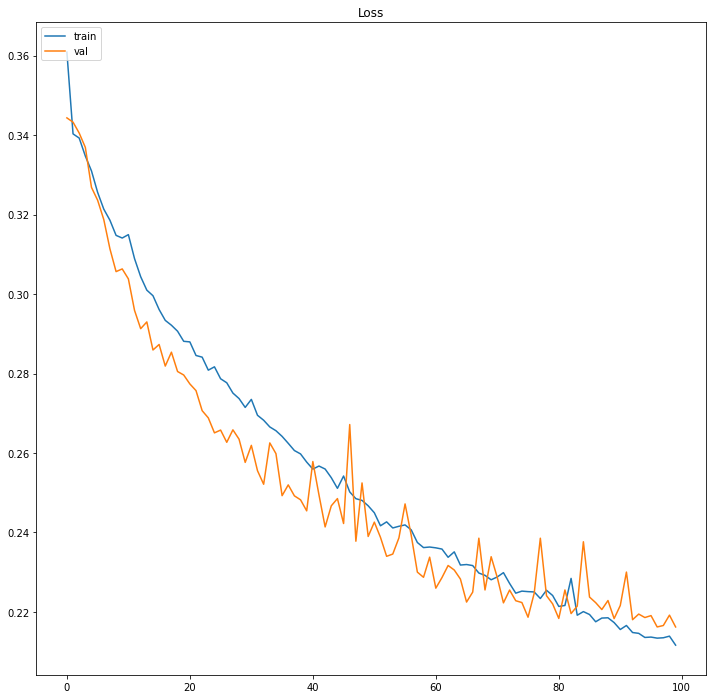

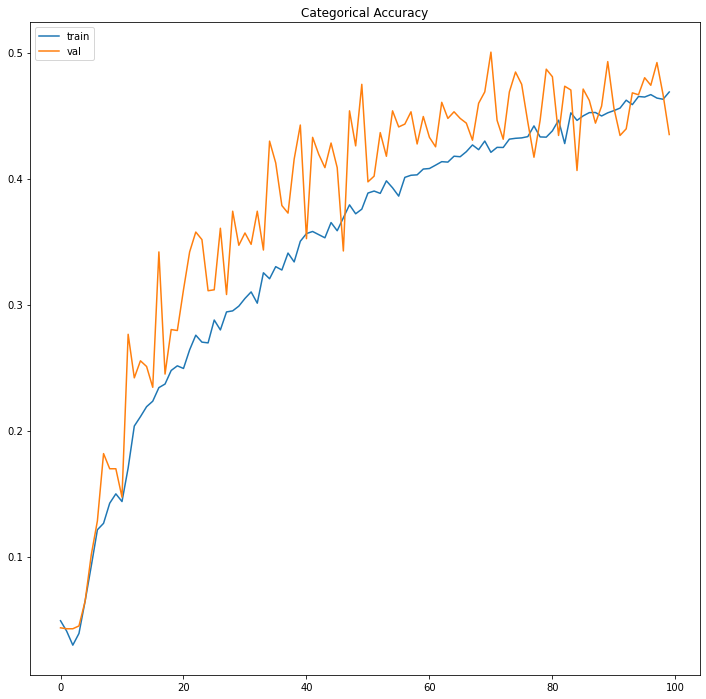

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Categorical Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
y_pred = clf.predict(X_test).round()
pd.DataFrame(y_pred)

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1326  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1327  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1328  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1329  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1330  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

       14   15  
0     0.0  0.0  
1     0.0  0.0  
2     0.0  0.0  
3     0.0  0.0  
4     0.0  0.0  
...   ...  ...  
1326  0.0  0.0  
1327  0.0  0.0  
1328  0.0  0.0  
1329  0.0  1.0  
1330  0.0  0.0  

[1331 rows x 16 columns]

In [19]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, zero_division=0)).transpose()

precision    recall  f1-score  support
0              0.837500  0.563025  0.673367    238.0
1              0.725410  0.517544  0.604096    342.0
2              0.811966  0.542857  0.650685    175.0
3              0.669355  0.471591  0.553333    176.0
4              0.779412  0.524752  0.627219    101.0
5              0.679487  0.456897  0.546392    116.0
6              0.960000  0.623377  0.755906     77.0
7              0.844444  0.404255  0.546763     94.0
8              0.704545  0.191358  0.300971    162.0
9              0.666667  0.323232  0.435374     99.0
10             0.625000  0.192308  0.294118     78.0
11             0.700000  0.677419  0.688525    124.0
12             0.649123  0.355769  0.459627    104.0
13             0.611111  0.224490  0.328358     98.0
14             0.730159  0.429907  0.541176    107.0
15             0.703325  0.613839  0.655542    448.0
micro avg      0.732774  0.481686  0.581274   2539.0
macro avg      0.731094  0.444539  0.541341   2539.0
weighted avg   0.730388  0.481686  0.569593   2539.0
samples avg    0.567418  0.493735  0.502647   2539.0

In [20]:
clf.fit(X_annotated, y_annotated, epochs=90, batch_size=64)

Epoch 1/90
208/208 [==============================] - 4s 20ms/step - loss: 0.2147 - categorical_accuracy: 0.4602
Epoch 2/90
208/208 [==============================] - 4s 19ms/step - loss: 0.2127 - categorical_accuracy: 0.4708
Epoch 3/90
208/208 [==============================] - 4s 19ms/step - loss: 0.2119 - categorical_accuracy: 0.4692
Epoch 4/90
208/208 [==============================] - 4s 20ms/step - loss: 0.2106 - categorical_accuracy: 0.4750
Epoch 5/90
208/208 [==============================] - 4s 20ms/step - loss: 0.2105 - categorical_accuracy: 0.4686
Epoch 6/90
208/208 [==============================] - 4s 20ms/step - loss: 0.2115 - categorical_accuracy: 0.4762
Epoch 7/90
208/208 [==============================] - 4s 20ms/step - loss: 0.2100 - categorical_accuracy: 0.4752
Epoch 8/90
208/208 [==============================] - 4s 20ms/step - loss: 0.2113 - categorical_accuracy: 0.4675
Epoch 9/90
208/208 [==============================] - 4s 20ms/step - loss: 0.2097 - categorical_

In [21]:
df_testing = pd.read_csv("testing_cleaned.csv").set_index("id").fillna("")
testing_text = (df_testing['judul_pertanyaan'] + " " + df_testing['isi_pertanyaan'])
testing_vectorized = vectorizer.transform(testing_text)

In [22]:
prediction = clf.predict(testing_vectorized).round().astype(int)
df_pred = pd.DataFrame(prediction).set_index(df_testing.index)
df_pred.to_csv("results_mph_lstm_word2vec_gdown_all.csv", header=False)